### 1) set up python libraries

In [ ]:
import warnings, numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import f as fdist
import matplotlib.pyplot as plt

### 2) Set up data fecthing

In [ ]:
START = "2015-01-01"
END = "2025-10-23"
FREQ = "W-FRI"

EQUITY_TICKERS = {
    "US": "^GSPC",
    "EU": "^STOXX50E",
    "JP": "^N225",
}

YAHOO_3M = "^IRX"  # 1.00 ≈ 1 bp
YAHOO_10Y = "^TNX"  # 1.00 ≈ 10 bp

# Transition variable
VIX_TICKER = "^VIX"

# Shock x for the first pass: "US_10Y"
X_SOURCE = "US_10Y"


### 3) Data fecthing  using `yfinance`, resampling to last friday of each week, obtaining log returns for equitites and simples differences for US3M and US10Y

In [ ]:
def _resample_last(df: pd.DataFrame, freq: str) -> pd.DataFrame:
    return df.resample(freq).last()

def fetch_equities_yahoo(ticker_map, start, end, freq):
    frames = []
    for unit, ticker in ticker_map.items():
        px = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=False)[["Close"]]
        px.columns = [unit]
        frames.append(px)
    wide = pd.concat(frames, axis=1).dropna(how="all")
    wide = _resample_last(wide, freq).dropna(how="any")
    return wide


def fetch_vix_yahoo(start, end, freq):
    vix = yf.download(VIX_TICKER, start=start, end=end, progress=False, auto_adjust=False)[["Close"]]
    vix.columns = ["VIX"]
    vix = _resample_last(vix, freq).dropna()
    return vix["VIX"]


def fetch_rates_yahoo(start, end, freq):
    irx = yf.download(YAHOO_3M, start=start, end=end, progress=False, auto_adjust=False)[["Close"]].rename(
        columns={"Close": "IRX"})
    tnx = yf.download(YAHOO_10Y, start=start, end=end, progress=False, auto_adjust=False)[["Close"]].rename(
        columns={"Close": "TNX"})
    rates = pd.concat([irx, tnx], axis=1)
    rates = _resample_last(rates, freq).dropna()
    out = pd.DataFrame(index=rates.index)
    out["US_3M_level_yahoo"] = rates["IRX"]
    out["US_10Y_level_yahoo"] = rates["TNX"]
    # changes in bps
    out["d_US_3M_bps"] = rates["IRX"].diff()  # IRX: 1.00 ~ 1 bp
    out["d_US_10Y_bps"] = rates["TNX"].diff() * 10.0  # TNX: 1.00 ~ 10 bp
    return out.dropna()


def log_returns(levels_df: pd.DataFrame) -> pd.DataFrame:
    return np.log(levels_df).diff().dropna()

px.head():
                      US           EU            JP
Date                                              
2015-01-09  2044.810059  3042.899902  17197.730469
2015-01-16  2019.420044  3202.239990  16864.160156
2015-01-23  2051.820068  3382.550049  17511.750000
2015-01-30  1994.989990  3351.439941  17674.390625
2015-02-06  2055.469971  3398.159912  17648.500000 

rets.head():
                   US        EU        JP
Date                                    
2015-01-16 -0.012495  0.051040 -0.019587
2015-01-23  0.015917  0.054779  0.037681
2015-01-30 -0.028088 -0.009240  0.009245
2015-02-06  0.029865  0.013844 -0.001466
2015-02-13  0.019998  0.014441  0.014896 

vix.head():
 Date
2015-01-02    17.790001
2015-01-09    17.549999
2015-01-16    20.950001
2015-01-23    16.660000
2015-01-30    20.969999
Freq: W-FRI, Name: VIX, dtype: float64 

rates.head():
             US_3M_level_yahoo  US_10Y_level_yahoo  d_US_3M_bps  d_US_10Y_bps
Date                                                   

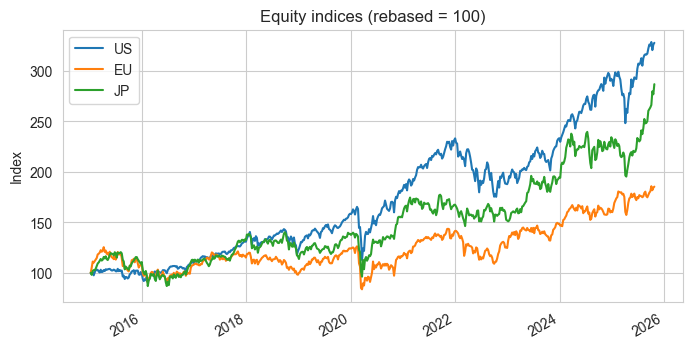

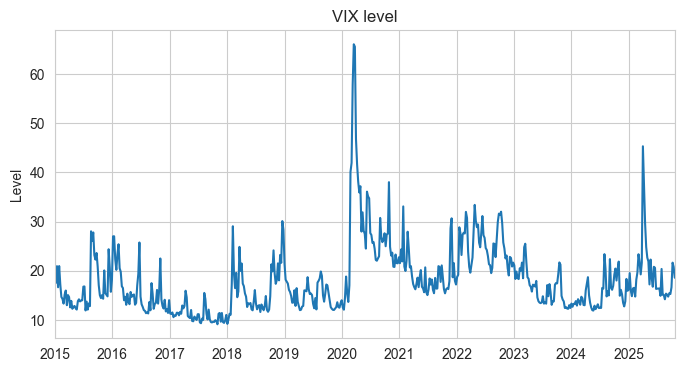

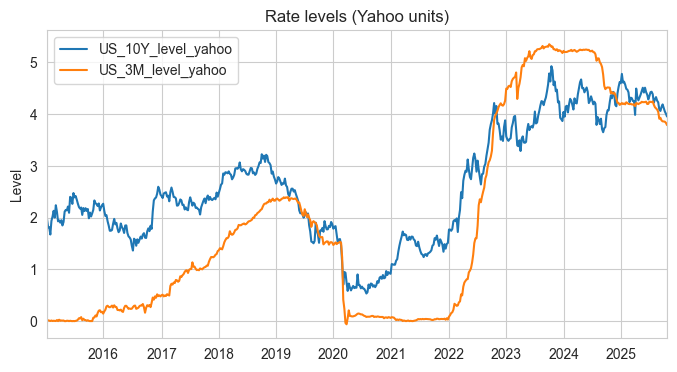

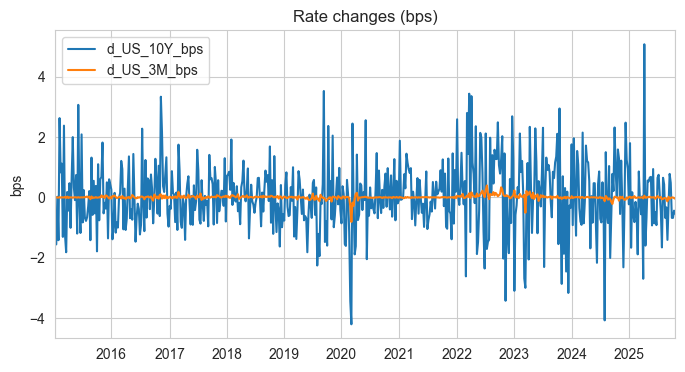

In [7]:
# 1) Quick heads
print("px.head():\n", px.head(), "\n")
print("rets.head():\n", np.log(px).diff().dropna().head(), "\n")  # rets if you didn't keep it
print("vix.head():\n", vix.head(), "\n")
print("rates.head():\n", rates.head(), "\n")

# 2) Describe (basic stats)
print("\n=== DESCRIBE: Equity levels (px) ===\n", px.describe())
print("\n=== DESCRIBE: Equity log-returns (rets) ===\n", np.log(px).diff().dropna().describe())
print("\n=== DESCRIBE: VIX ===\n", vix.describe())
print("\n=== DESCRIBE: Rates (levels + diffs) ===\n", rates.describe())

# 3) Correlation (returns vs rate diffs)
rets = np.log(px).diff().dropna()
corr_df = rets.join(rates[["d_US_10Y_bps","d_US_3M_bps"]], how="inner").corr()
print("\n=== CORRELATION MATRIX (rets & rate diffs) ===\n", corr_df)

# 4) Very simple plots: evolution over time
(px / px.iloc[0] * 100).plot(title="Equity indices (rebased = 100)")
plt.xlabel(""); plt.ylabel("Index"); plt.show()

vix.plot(title="VIX level")
plt.xlabel(""); plt.ylabel("Level"); plt.show()

rates[["US_10Y_level_yahoo","US_3M_level_yahoo"]].plot(title="Rate levels (Yahoo units)")
plt.xlabel(""); plt.ylabel("Level"); plt.show()

rates[["d_US_10Y_bps","d_US_3M_bps"]].plot(title="Rate changes (bps)")
plt.xlabel(""); plt.ylabel("bps"); plt.show()


Panel shape: (1686, 6)
unit
EU    562
JP    562
US    562
Name: date, dtype: int64
    count      mean       std       min        1%        5%       25%  \
y  1686.0  0.001695  0.026095 -0.223003 -0.072874 -0.039609 -0.010658   
x  1686.0  0.034804  1.168002 -4.210000 -3.099999 -1.819999 -0.680001   
q  1686.0  2.619980  1.128417  0.536000  0.628000  0.749000  1.755000   

        50%      75%       95%       99%       max  
y  0.003201  0.01564  0.039711  0.062998  0.158171  
x -0.010000  0.73000  2.110000  3.069999  5.080001  
q  2.393000  3.69500  4.441000  4.629000  4.924000  


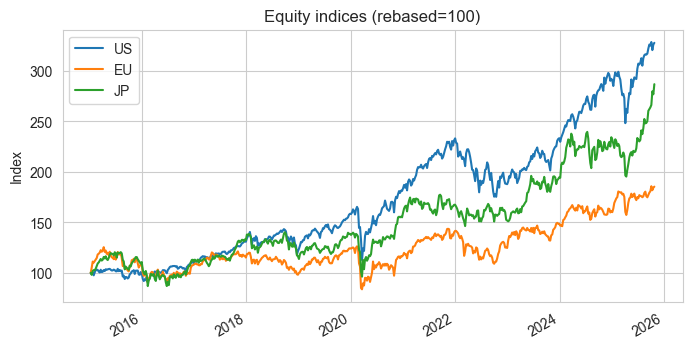

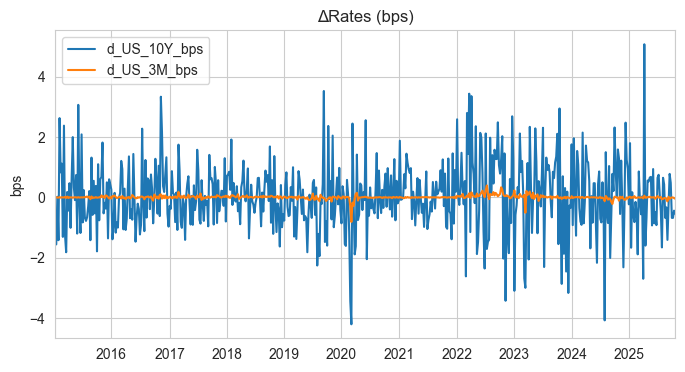

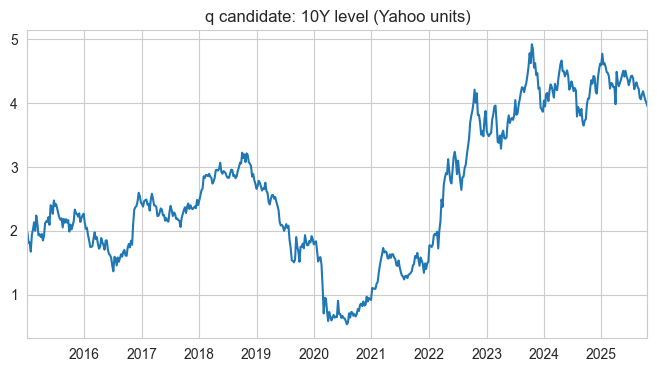

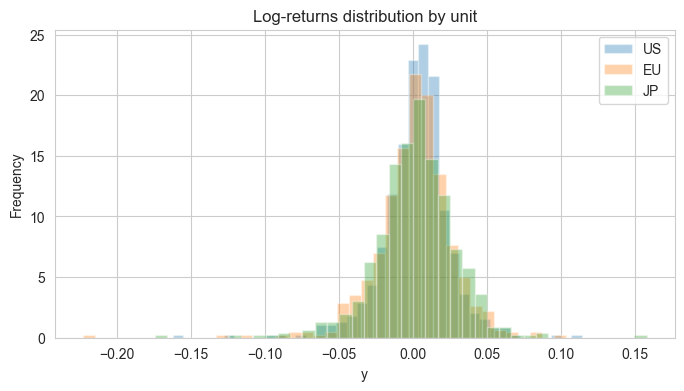

Linearity test (unit FE, partialed): F(3,1682)=21.754, p=0.0000
PSTR(1) unit-FE results (cluster-by-date):
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.233e-19      0.001  -3.46e-16      1.000      -0.002       0.002
x1             0.0096      0.003      3.429      0.001       0.004       0.015
x2            -0.0258      0.008     -3.324      0.001      -0.041      -0.011


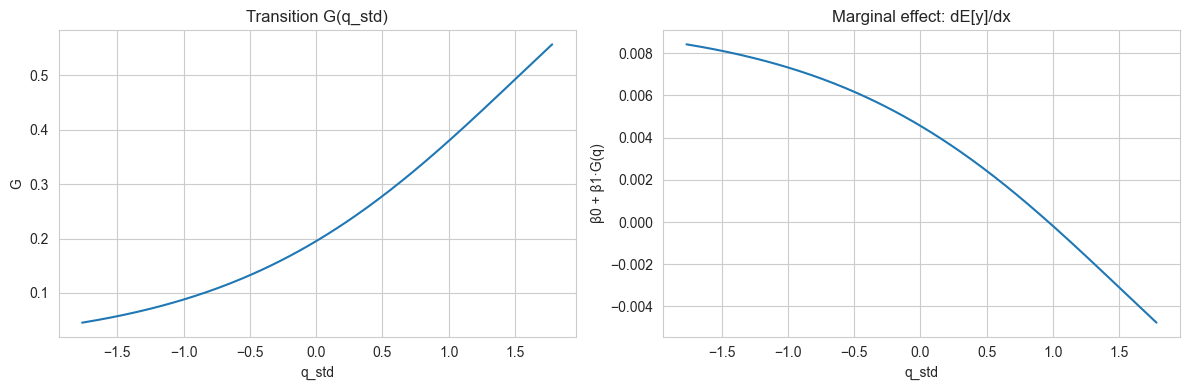

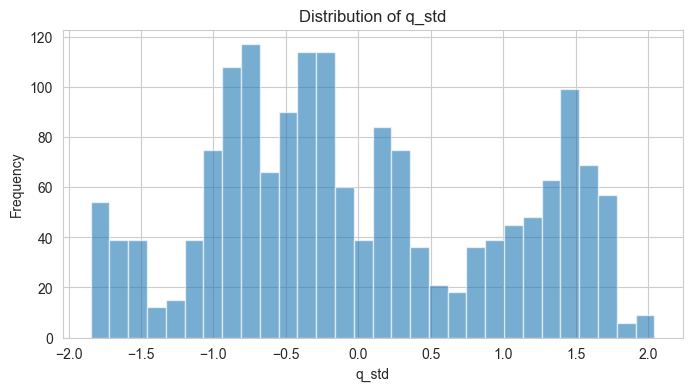

Monthly TRUE panel (FRED) shape: (381, 6)
        date unit         y          x         q     q_std
0 2015-03-31   US -0.017549   6.000000  2.040000  0.583323
1 2015-03-31   DE  0.048325  -7.472727  0.227273 -0.717652
2 2015-03-31   JP  0.021527   7.000000  0.400000 -0.593688
3 2015-04-30   US  0.008485 -10.000000  1.940000  0.511554
4 2015-04-30   DE -0.043711 -10.527273  0.122000 -0.793205
Linearity test (two-way FE, partialed): F(3,377)=3.336, p=0.0195
PSTR(1) two-way FE (cluster-by-unit):
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -3.6e-19   5.81e-19     -0.619      0.536    -1.5e-18    7.79e-19
x1             0.0011      0.000      2.600      0.009       0.000       0.002
x2            -0.0014      0.000     -3.088      0.002      -0.002      -0.001


In [4]:



def to_long_panel(wide_df: pd.DataFrame, name: str) -> pd.DataFrame:
    out = wide_df.stack().rename(name).to_frame()
    out.index.set_names(["date", "unit"], inplace=True)
    return out.reset_index()


def build_panel(px_wide: pd.DataFrame, rates_df: pd.DataFrame, q_series: pd.Series, x_source="US_10Y"):
    # returns per unit
    r_wide = log_returns(px_wide)
    y_long = to_long_panel(r_wide, "y")

    # shock x
    if x_source == "US_10Y":
        x = rates_df["d_US_10Y_bps"].copy()
    elif x_source == "US_3M":
        x = rates_df["d_US_3M_bps"].copy()
    else:
        raise ValueError("x_source must be 'US_10Y' or 'US_3M'")
    x = x.rename("x").dropna()

    # transition q (Series)
    if isinstance(q_series, pd.DataFrame):
        q = q_series.iloc[:, 0]
    else:
        q = q_series
    q = q.rename("q").dropna()

    # Align dates
    common_idx = r_wide.index.intersection(x.index).intersection(q.index)
    r_wide = r_wide.loc[common_idx]
    x = x.loc[common_idx]
    q = q.loc[common_idx]

    # Broadcast x, q across units
    x_long = pd.DataFrame({"date": common_idx, "x": x.values})
    q_long = pd.DataFrame({"date": common_idx, "q": q.values})
    panel = to_long_panel(r_wide, "y").merge(x_long, on="date").merge(q_long, on="date")

    # Standardize q
    panel["q_std"] = (panel["q"] - panel["q"].mean()) / panel["q"].std(ddof=0)

    # Balance the panel
    counts = panel.groupby("unit")["date"].count()
    full_T = counts.max()
    keep_units = counts[counts == full_T].index
    panel_bal = panel[panel["unit"].isin(keep_units)].reset_index(drop=True)

    return panel_bal[["date", "unit", "y", "x", "q", "q_std"]]


# 3) BUILD WEEKLY PANEL (Yahoo) + EDA
#---------------------------------------------------------------
px = fetch_equities_yahoo(EQUITY_TICKERS, START, END, FREQ)
rates = fetch_rates_yahoo(START, END, FREQ)
vix = fetch_vix_yahoo(START, END, FREQ)

# Choose q (you can switch below). Here: q = 10Y level (Yahoo units)
q_10y = rates["US_10Y_level_yahoo"]

# Build panel with x = Δ10Y (bps) initially
panel = build_panel(px_wide=px, rates_df=rates, q_series=q_10y, x_source=X_SOURCE)

# ---- Descriptives / EDA ----
print("Panel shape:", panel.shape)
print(panel.groupby("unit")["date"].count())
print(panel[["y", "x", "q"]].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

# Levels rebased
(px / px.iloc[0] * 100).plot(title="Equity indices (rebased=100)")
plt.xlabel("");
plt.ylabel("Index");
plt.show()

# Δrates (bps) and q over time
rates[["d_US_10Y_bps", "d_US_3M_bps"]].plot(title="ΔRates (bps)")
plt.xlabel("");
plt.ylabel("bps");
plt.show()

q_10y.plot(title="q candidate: 10Y level (Yahoo units)");
plt.xlabel("");
plt.show()

# Return distributions
for u in panel["unit"].unique():
    panel.loc[panel["unit"] == u, "y"].plot(kind="hist", bins=40, alpha=0.35, density=True, label=u)
plt.title("Log-returns distribution by unit");
plt.xlabel("y");
plt.legend();
plt.show()


# 4) LINEARITY TESTS (UNIT-FE, PARTIALED)
#---------------------------------------------------------------
def unit_demean(s: pd.Series, unit: pd.Series) -> np.ndarray:
    df = pd.DataFrame({"s": s.values, "unit": unit.values})
    si = df.groupby("unit")["s"].transform("mean")
    return (df["s"] - si).values


def linearity_test_unitFE_partial(panel: pd.DataFrame):
    df = panel.copy()
    z = (df["q"] - df["q"].mean()) / df["q"].std(ddof=0)  # standardized q

    # unit-demean
    y_dm = unit_demean(df["y"], df["unit"])
    x_dm = unit_demean(df["x"], df["unit"])
    xz_dm = unit_demean(df["x"] * z, df["unit"])
    xz2_dm = unit_demean(df["x"] * (z ** 2), df["unit"])
    xz3_dm = unit_demean(df["x"] * (z ** 3), df["unit"])

    # Restricted: y_dm ~ const + x_dm
    Xr = sm.add_constant(x_dm)
    rr = sm.OLS(y_dm, Xr).fit()

    # Partial-out x_dm from y and the 3 nonlinear regressors (Frisch–Waugh–Lovell)
    y_res = rr.resid
    Z = np.column_stack([xz_dm, xz2_dm, xz3_dm])
    Z_res = np.empty_like(Z)
    for j in range(Z.shape[1]):
        Z_res[:, j] = sm.OLS(Z[:, j], Xr).fit().resid

    # Auxiliary: y_res ~ const + Z_res
    Xu = sm.add_constant(Z_res)
    ur = sm.OLS(y_res, Xu).fit()
    RSS0 = np.sum(y_res ** 2)
    RSSu = ur.ssr
    df_num, df_den = 3, int(ur.df_resid)
    F = ((RSS0 - RSSu) / df_num) / (RSSu / df_den)
    pF = 1 - fdist.cdf(F, df_num, df_den)
    print(f"Linearity test (unit FE, partialed): F({df_num},{df_den})={F:.3f}, p={pF:.4f}")
    return {"F": F, "pval": pF, "ur": ur}


lin_test = linearity_test_unitFE_partial(panel)


# 5) PSTR(1) ESTIMATION (UNIT FE), plus marginal effect plots
#---------------------------------------------------------------
def G_logistic(q_std, gamma, c):
    return 1.0 / (1.0 + np.exp(-gamma * (q_std - c)))


def pstr_objective_unitFE(params, df, qname="q_std"):
    gamma, c = params
    if gamma <= 1e-4:
        return 1e12
    qstd = df[qname].values
    x = df["x"].values
    y = df["y"].values
    u = df["unit"]

    G = G_logistic(qstd, gamma, c)
    y_dm = unit_demean(pd.Series(y), u)
    x_dm = unit_demean(pd.Series(x), u)
    xG_dm = unit_demean(pd.Series(x * G), u)

    X = np.column_stack([x_dm, xG_dm])  # [x, x*G]
    beta_hat = np.linalg.lstsq(X, y_dm, rcond=None)[0]
    resid = y_dm - X @ beta_hat
    return float(resid @ resid)


def estimate_pstr_unitFE(panel: pd.DataFrame, gamma_bounds=(0.5, 20.0)):
    df = panel.copy()

    # Grid init
    qs = df["q_std"].quantile([0.2, 0.4, 0.6, 0.8]).values
    gammas = [1.0, 5.0, 10.0, 15.0]
    init_grid = [(g, c0) for g in gammas for c0 in qs]

    best = None;
    best_val = np.inf
    for g0, c0 in init_grid:
        val = pstr_objective_unitFE((g0, c0), df)
        if val < best_val:
            best_val, best = val, (g0, c0)

    # Local refine
    bounds = ((gamma_bounds[0], gamma_bounds[1]), (-3.0, 3.0))  # c in z-units
    opt = minimize(lambda p: pstr_objective_unitFE(p, df),
                   x0=np.array(best), method="L-BFGS-B", bounds=bounds)
    gamma_hat, c_hat = opt.x

    # Final OLS (cluster by date)
    qstd = df["q_std"].values
    G = G_logistic(qstd, gamma_hat, c_hat)
    y_dm = unit_demean(df["y"], df["unit"])
    x_dm = unit_demean(df["x"], df["unit"])
    xG_dm = unit_demean(pd.Series(df["x"].values * G), df["unit"])

    X = np.column_stack([x_dm, xG_dm])
    ols = sm.OLS(y_dm, sm.add_constant(X)).fit(cov_type="cluster", cov_kwds={"groups": df["date"]})
    beta0, beta1 = ols.params[1], ols.params[2]
    se0, se1 = ols.bse[1], ols.bse[2]

    print("PSTR(1) unit-FE results (cluster-by-date):")
    print(ols.summary().tables[1])

    out = {
        "gamma": gamma_hat, "c": c_hat,
        "beta0": beta0, "beta1": beta1,
        "beta_low": beta0, "beta_high": beta0 + beta1,
        "se_beta0": se0, "se_beta1": se1,
        "ols": ols, "G": G,
        "y_dm": y_dm, "X": X
    }
    return out


pstr = estimate_pstr_unitFE(panel)

# Marginal effect and transition plots
q_grid = np.linspace(panel["q_std"].quantile(0.01), panel["q_std"].quantile(0.99), 250)
G_grid = G_logistic(q_grid, pstr["gamma"], pstr["c"])
me_grid = pstr["beta0"] + pstr["beta1"] * G_grid

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(q_grid, G_grid);
ax[0].set_title("Transition G(q_std)");
ax[0].set_xlabel("q_std");
ax[0].set_ylabel("G")
ax[1].plot(q_grid, me_grid);
ax[1].set_title("Marginal effect: dE[y]/dx");
ax[1].set_xlabel("q_std");
ax[1].set_ylabel("β0 + β1·G(q)")
plt.tight_layout();
plt.show()

panel["q_std"].plot(kind="hist", bins=30, alpha=0.6, title="Distribution of q_std");
plt.xlabel("q_std");
plt.show()

# 6) OPTIONAL: swap x to Δ3M (bps) and add lagged x, then re-estimate
#---------------------------------------------------------------
# Switch x to Δ3M (bps)
panel_x3m = panel.copy()
panel_x3m["x"] = rates["d_US_3M_bps"].reindex(panel_x3m["date"]).values
panel_x3m = panel_x3m.dropna()

# Add lagged x
panel_x3m["x_lag"] = panel_x3m.groupby("unit")["x"].shift(1)
panel_x3m = panel_x3m.dropna()


def estimate_pstr_unitFE_wlag(panel_df: pd.DataFrame, gamma_bounds=(0.5, 20.0)):
    df = panel_df.copy()
    qs = df["q_std"].quantile([0.2, 0.4, 0.6, 0.8]).values
    gammas = [1.0, 5.0, 10.0, 15.0]
    init_grid = [(g, c0) for g in gammas for c0 in qs]

    def obj(params):
        gamma, c = params
        if gamma <= 1e-4: return 1e12
        G = 1.0 / (1.0 + np.exp(-gamma * (df["q_std"].values - c)))
        y_dm = unit_demean(df["y"], df["unit"])
        x_dm = unit_demean(df["x"], df["unit"])
        xG_dm = unit_demean(pd.Series(df["x"].values * G), df["unit"])
        xl_dm = unit_demean(df["x_lag"], df["unit"])
        xlG_dm = unit_demean(pd.Series(df["x_lag"].values * G), df["unit"])
        X = np.column_stack([x_dm, xG_dm, xl_dm, xlG_dm])
        beta = np.linalg.lstsq(X, y_dm, rcond=None)[0]
        resid = y_dm - X @ beta
        return float(resid @ resid)

    # grid
    best, best_val = None, np.inf
    for g0, c0 in init_grid:
        v = obj((g0, c0))
        if v < best_val: best_val, best = v, (g0, c0)

    # local
    bounds = ((gamma_bounds[0], gamma_bounds[1]), (-3.0, 3.0))
    opt = minimize(lambda p: obj(p), x0=np.array(best), method="L-BFGS-B", bounds=bounds)
    gamma_hat, c_hat = opt.x

    # final OLS (cluster by date)
    G = 1.0 / (1.0 + np.exp(-gamma_hat * (df["q_std"].values - c_hat)))
    y_dm = unit_demean(df["y"], df["unit"])
    x_dm = unit_demean(df["x"], df["unit"])
    xG_dm = unit_demean(pd.Series(df["x"].values * G), df["unit"])
    xl_dm = unit_demean(df["x_lag"], df["unit"])
    xlG_dm = unit_demean(pd.Series(df["x_lag"].values * G), df["unit"])

    X = np.column_stack([x_dm, xG_dm, xl_dm, xlG_dm])
    ols = sm.OLS(y_dm, sm.add_constant(X)).fit(cov_type="cluster", cov_kwds={"groups": df["date"]})
    print("PSTR(1) with x and x_lag (cluster-by-date):")
    print(ols.summary().tables[1])
    return {"gamma": gamma_hat, "c": c_hat, "ols": ols}


# Run (uncomment to test)
# res_x3m_wlag = estimate_pstr_unitFE_wlag(panel_x3m)

# 7) OPTIONAL: TRUE monthly panel with unit-specific rates (FRED) + two-way FE
#     This block includes the robust reshape that fixes KeyError: 'date'
#---------------------------------------------------------------
if HAVE_FRED:
    # 7.1 FRED series (OECD long-term yields, percent)
    COUNTRY_LT10 = {
        "US": "IRLTLT01USM156N",
        "DE": "IRLTLT01DEM156N",
        "JP": "IRLTLT01JPM156N",
    }
    START_M, END_M = "2015-01-01", "2025-10-01"

    lt_frames = []
    for c, code in COUNTRY_LT10.items():
        s = web.DataReader(code, "fred", START_M, END_M).rename(columns={code: c})
        lt_frames.append(s)
    lt10_pct = pd.concat(lt_frames, axis=1).resample("M").last().dropna(how="any")  # monthly percent
    dlt10_bps = lt10_pct.diff() * 100.0  # Δ in bps

    # 7.2 Monthly equities for the same units (BM = business month-end)
    TICKERS = {"US": "^GSPC", "DE": "^GDAXI", "JP": "^N225"}
    px_m = []
    for u, t in TICKERS.items():
        df = yf.download(t, start=START_M, end=END_M, progress=False, auto_adjust=False)[["Close"]]
        df.columns = [u]
        px_m.append(df)
    px_m = pd.concat(px_m, axis=1).resample("BM").last().dropna(how="any")

    # --- Align rates to the equity month-end business dates ---
    lt10_aligned = lt10_pct.reindex(px_m.index).ffill().dropna()
    dlt10_aligned = dlt10_bps.reindex(px_m.index).ffill().dropna()

    # --- Build monthly equity return panel (robust long reshape) ---
    r_m = np.log(px_m).diff().dropna()
    panel_m = r_m.stack().rename("y").rename_axis(index=["date", "unit"]).reset_index()

    # --- Robust long reshapes for rates (avoid KeyError: 'date') ---
    x_long = (
        dlt10_aligned
        .stack()
        .rename("x")
        .rename_axis(index=["date", "unit"])
        .reset_index()
    )

    q_long = (
        lt10_aligned
        .stack()
        .rename("q")
        .rename_axis(index=["date", "unit"])
        .reset_index()
    )

    # --- Merge by ['date','unit'] safely ---
    panel_m = panel_m.merge(x_long, on=["date", "unit"], how="inner")
    panel_m = panel_m.merge(q_long, on=["date", "unit"], how="inner")

    # --- Standardize q and balance the panel ---
    panel_m["q_std"] = (panel_m["q"] - panel_m["q"].mean()) / panel_m["q"].std(ddof=0)
    counts = panel_m.groupby("unit")["date"].count()
    panel_m = panel_m[panel_m["unit"].isin(counts[counts == counts.max()].index)].reset_index(drop=True)

    print("Monthly TRUE panel (FRED) shape:", panel_m.shape)
    print(panel_m.head())


    # 7.3 Two-way demeaning helpers and tests
    def double_demean(s: pd.Series, unit: pd.Series, time: pd.Series) -> np.ndarray:
        df = pd.DataFrame({"s": s.values, "unit": unit.values, "time": time.values})
        si = df.groupby("unit")["s"].transform("mean")
        st = df.groupby("time")["s"].transform("mean")
        sbar = df["s"].mean()
        return (df["s"] - si - st + sbar).values


    def linearity_test_2way_partial(panel_df: pd.DataFrame):
        df = panel_df.copy()
        z = (df["q"] - df["q"].mean()) / df["q"].std(ddof=0)
        y_dd = double_demean(df["y"], df["unit"], df["date"])
        x_dd = double_demean(df["x"], df["unit"], df["date"])
        xz_dd = double_demean(df["x"] * z, df["unit"], df["date"])
        xz2_dd = double_demean(df["x"] * (z ** 2), df["unit"], df["date"])
        xz3_dd = double_demean(df["x"] * (z ** 3), df["unit"], df["date"])

        # Restricted
        Xr = sm.add_constant(x_dd)
        rr = sm.OLS(y_dd, Xr).fit()

        # Partial-out x_dd from y_dd and the nonlinear regressors
        y_res = rr.resid
        Z = np.column_stack([xz_dd, xz2_dd, xz3_dd])
        Z_res = np.empty_like(Z)
        for j in range(Z.shape[1]):
            Z_res[:, j] = sm.OLS(Z[:, j], Xr).fit().resid

        Xu = sm.add_constant(Z_res)
        ur = sm.OLS(y_res, Xu).fit()
        RSS0 = np.sum(y_res ** 2);
        RSSu = ur.ssr
        df_num, df_den = 3, int(ur.df_resid)
        F = ((RSS0 - RSSu) / df_num) / (RSSu / df_den)
        pF = 1 - fdist.cdf(F, df_num, df_den)
        print(f"Linearity test (two-way FE, partialed): F({df_num},{df_den})={F:.3f}, p={pF:.4f}")
        return {"F": F, "pval": pF, "ur": ur}


    lin2 = linearity_test_2way_partial(panel_m)


    # 7.4 PSTR(1) with two-way FE (double-demeaned)
    def pstr_objective_2way(params, df, qname="q_std"):
        gamma, c = params
        if gamma <= 1e-4: return 1e12
        qstd = df[qname].values
        G = 1.0 / (1.0 + np.exp(-gamma * (qstd - c)))
        y_dd = double_demean(df["y"], df["unit"], df["date"])
        x_dd = double_demean(df["x"], df["unit"], df["date"])
        xG_dd = double_demean(pd.Series(df["x"].values * G), df["unit"], df["date"])
        X = np.column_stack([x_dd, xG_dd])
        beta = np.linalg.lstsq(X, y_dd, rcond=None)[0]
        resid = y_dd - X @ beta
        return float(resid @ resid)


    def estimate_pstr_2way(panel_df: pd.DataFrame, gamma_bounds=(0.5, 20.0)):
        df = panel_df.copy()
        qs = df["q_std"].quantile([0.2, 0.4, 0.6, 0.8]).values
        gammas = [1.0, 5.0, 10.0, 15.0]
        init_grid = [(g, c0) for g in gammas for c0 in qs]

        best, best_val = None, np.inf
        for g0, c0 in init_grid:
            v = pstr_objective_2way((g0, c0), df)
            if v < best_val: best_val, best = v, (g0, c0)

        bounds = ((gamma_bounds[0], gamma_bounds[1]), (-3.0, 3.0))
        opt = minimize(lambda p: pstr_objective_2way(p, df), x0=np.array(best),
                       method="L-BFGS-B", bounds=bounds)
        gamma_hat, c_hat = opt.x

        # Final OLS (cluster by unit as example; for robust inference consider bootstrap)
        qstd = df["q_std"].values
        G = 1.0 / (1.0 + np.exp(-gamma_hat * (qstd - c_hat)))
        y_dd = double_demean(df["y"], df["unit"], df["date"])
        x_dd = double_demean(df["x"], df["unit"], df["date"])
        xG_dd = double_demean(pd.Series(df["x"].values * G), df["unit"], df["date"])

        X = np.column_stack([x_dd, xG_dd])
        ols = sm.OLS(y_dd, sm.add_constant(X)).fit(cov_type="cluster", cov_kwds={"groups": df["unit"]})
        print("PSTR(1) two-way FE (cluster-by-unit):")
        print(ols.summary().tables[1])
        return {"gamma": gamma_hat, "c": c_hat, "ols": ols, "G": G}


    pstr2 = estimate_pstr_2way(panel_m)

else:
    print("Skip TRUE panel (need pandas_datareader). You can install it and re-run this cell.")
